# A first journey through CNN

In [1]:
] activate .

The above is to make sure we are using the same libraries  

In [2]:
using Flux, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition
using Images

## Getting our Data Set

In [3]:
using MLDatasets
# load full training set
train_x, train_y = CIFAR10.traindata();
train_y = onehotbatch(train_y, 0:9);
# load full test set
test_x,  test_y  = CIFAR10.testdata();
test_y = onehotbatch(test_y, 0:9);

The CIFAR10 data set will be downloaded....if run this for the first time. 
CIFAR10 is a collection of small image... lets have a look 

In [4]:
train_x |> size

(32, 32, 3, 50000)

From the that we can assume that we have 50,000 image. Each image is 32x32 in RGB space. Julia provides a convenient `colorview` function for make conversion for the matrix to a viewable image.  

## Looking at our images

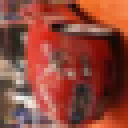

In [5]:
colorview(RGB, [train_x[:,:,i,6] for i=1:3]...)

So form the above we can guess that this rather low-res image of red car. In the above code, we have generated an array for arrays (`[train_x[:,:,i,6] for i=1:3]`) where each element is 2D array for each color channel (i.e. Red, Green, Blue). We take that array and splat it (using `...`) into the [`colorview`](http://juliaimages.github.io/latest/function_reference.html#ImageCore.colorview) function. So we can get viewable image. For the `Julia` beginner this might look a bit complex. Julia save us a great deal of for loops if we know how handle array indices. We can write a function with loops to get the same effect. Here is one:

In [6]:
function float2RGB(img)
    imgrgb = zeros(RGB{Normed{UInt8,8}}, size(img, 1),size(img, 2))
    for i=1:size(img, 1)
        for j=1:size(img, 2)
            imgrgb[i, j] = RGB(img[i, j, 1], img[i, j, 2], img[i, j,3])
        end
    end
    imgrgb
end

float2RGB (generic function with 1 method)

We test it

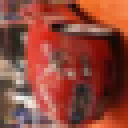

In [7]:
float2RGB(train_x[:,:,:,6])

...see same result. But if we are really good a `Julia`, an even more compact way, without creating array of arrays etc... is to use [`permutedims`](https://docs.julialang.org/en/v1/base/arrays/index.html#Base.permutedims). 

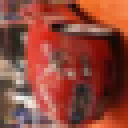

In [8]:
colorview(RGB, permutedims(train_x[:,:,:,6],[3,1,2]))

Same result. But with `permutedims` we get more flexibility...if our necks get tired looking sideways for the car we can do 

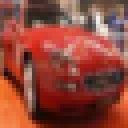

In [9]:
colorview(RGB, permutedims(train_x[:,:,:,6],[3,2,1]))

... a little better...don't you think?

Now if we memory conscious, we don't like allocate new memory to look at the image. We can use [PermutedDimsArray](https://docs.julialang.org/en/v1/base/arrays/index.html#Base.PermutedDimsArrays.PermutedDimsArray) to get a [view](https://docs.julialang.org/en/v1/base/arrays/index.html#Views-(SubArrays-and-other-view-types)-1) of our permuted image. 

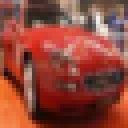

In [10]:
colorview(RGB,PermutedDimsArray(train_x[:,:,:,6],[3,2,1]))

Same result, but we saved some memory. 

## Manipulating our images

Before we even start doing CNNs we want to write a few simple functions to allow us to manipulate our images. 

In [11]:
function shiftToLeft(img, n)
    r, g, b = img[:, n+1:end, 1], img[:, n+1:end, 2], img[:, n+1:end, 3]
    r_shift = hcat(r, zeros(size(img, 1), n))
    g_shift = hcat(g, zeros(size(img, 1), n))
    b_shift = hcat(b, zeros(size(img, 1), n))
    shifted_img = zeros(size(img, 1), size(img, 2), 3)
    shifted_img[:, :, 1] = r_shift
    shifted_img[:, :, 2] = g_shift
    shifted_img[:, :, 3] = b_shift
    shifted_img
end

shiftToLeft (generic function with 1 method)

Lets see what this does

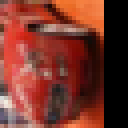

In [12]:
red_car=train_x[:,:,:,6]
shifted_red_car=shiftToLeft(red_car,6) # Shifted five pixels to the right
colorview(RGB,PermutedDimsArray(shifted_red_car,[3,1,2]))

In [13]:
function rotate_right(img)
    r, g, b = img[:, :, 1], img[:, :, 2], img[:, :, 3]
    rotated_img = zeros(size(img, 1), size(img, 2), 3)
    rotated_img[:, :, 1] = r'
    rotated_img[:, :, 2] = g'
    rotated_img[:, :, 3] = b'
    rotated_img
end

rotate_right (generic function with 1 method)

The name says it all. Lets see some rotation in action

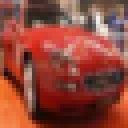

In [14]:
rotated_red_car=rotate_right(red_car)
colorview(RGB,PermutedDimsArray(rotated_red_car,[3,1,2]))

Note here that unlike what we did in the previous section via dimension permutation, here we rotated the original 3-dimensional input. 

A question for those who love elegant  students: **Can we write `rotate_right` and `shiftToLeft` more compactly and elegantly?**

Finally we write a convenience method to just show our images with minimum fuss. 

In [15]:
function showImage(img)
    colorview(RGB,PermutedDimsArray(img,[3,1,2]))
end

showImage (generic function with 1 method)

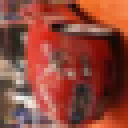

In [16]:
showImage(red_car)

## Some function for shifting and manipulating the  whole data set around

In [17]:
"""
Takes a particular class in a data set. Makes copy of it, shifts the copy
by a random amount and appends to the bottom of new (shifted) data set
"""
function createShiftedTrainDataSet(X, Y,  class_num)
    indxs = findall(Y[class_num, :] .== true) # finding all the incides of the `class_num`
    X_shifted = zeros(32, 32, 3, size(X, 4) + length(indxs))
    X_shifted[:,:,:, 1:size(X, 4)] = deepcopy(X)
    counter = size(X, 4) + 1
    for indx in indxs
        X_shifted[:, :, :, counter] = shiftToLeft(X[:, :, :, indx], rand(1:32));
        counter += 1;
    end
    Y_shifted = hcat(Y, Y[:, indxs])
    X_shifted, Y_shifted
end

createShiftedTrainDataSet

In [18]:
"""
Takes the original data, selects the a particular class (class_num), and outputs
a shifted copy of that class
"""
function createShiftedTestDataSet(X, Y,  class_num)
    indxs = findall(Y[class_num, :] .== true)
    X_shifted = zeros(32, 32, 3, length(indxs))
    counter = 1
    for indx in indxs
        X_shifted[:, :, :, counter] = shiftToLeft(X[:, :, :, indx], rand(1:32));
        counter += 1;
    end
    #Y_shifted = hcat(Y[:, indxs], Y[:, indxs])
    Y_shifted = Y[:, indxs]
    X_shifted, Y_shifted
end

createShiftedTestDataSet

In [19]:
"""
Creates a data set for training out of a list of `classes` 
"""
function createDataSetForClasses(X, Y, classes)
    indxs = []
    for class_num in classes
        append!(indxs, findall(Y[class_num, :] .== true))
    end
    X_dataSet = X[:, :, :, indxs]
    Y_dataSet = Y[:, indxs]
    X_dataSet, Y_dataSet
end

createDataSetForClasses

## Straight forward Training DataSet

Here we just work on three classes. Can you get example images to find out what those classes are

In [20]:
X, Y = createDataSetForClasses(train_x, train_y, [8, 9, 10]);
size(X)

(32, 32, 3, 15000)

## Shifted Training DataSet Trucks

In [21]:
X_shifted_trucks, Y_shifted_trucks = createShiftedTrainDataSet(X, Y, 10);
size(X_shifted_trucks)

(32, 32, 3, 20000)

## Shifted Testing DataSet Trucks

In [22]:
X_test_shifted_trucks, Y_test_shifted_trucks = createShiftedTestDataSet(test_x, test_y, 10);
size(X_test_shifted_trucks)

(32, 32, 3, 1000)

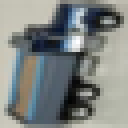

In [23]:
# 10 is truck class
index = findall(Y[10, :] .== true)
truck_train = X[:, :, :, index]
showImage(truck_train[:,:,:,42])

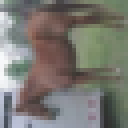

In [24]:
showImage(X[:, :, :, 220])

# CNN

In [25]:
m = Chain(
    Conv((2,2), 3=>16, relu),
    x -> maxpool(x, (2,2)), # maxpool default stride = k e.g. (2,2)
    x -> reshape(x, :, size(x, 4)),
    Dense(3600, 10), 
    softmax
)
loss(x, y) = crossentropy(m(x), y)
accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

function train_CNN_n(X, Y, dataset,n)
    evalcb = throttle(() -> @show(accuracy(X, Y)), 10)
    opt = ADAM(params(m))
    for i=1:n
        Flux.train!(loss, dataset, opt, cb = evalcb)
    end
end

function test_CNN(X, Y)
    accuracy(X, Y)
end

test_CNN (generic function with 1 method)

## Training on normal DataSet 

In [26]:
X = convert(Array{Float64,4}, X);

In [27]:
batches=[(X[:,:,:,i],Y[:,i]) for i in partition(1:size(X,4),500)] ;

In [28]:
train_CNN_n(X, Y, batches,5);

accuracy(X, Y) = 0.3328
accuracy(X, Y) = 0.3333333333333333
accuracy(X, Y) = 0.3333333333333333
accuracy(X, Y) = 0.3333333333333333
accuracy(X, Y) = 0.3334666666666667
accuracy(X, Y) = 0.4010666666666667
accuracy(X, Y) = 0.44066666666666665


In [29]:
test_CNN(X,Y)

0.3474

In [30]:
test_CNN(X_test_shifted_trucks, Y_test_shifted_trucks)

0.429

## Training on shifted DataSet

In [31]:
X_shifted_trucks = convert(Array{Float64,4}, X_shifted_trucks);
batches=[(X_shifted_trucks[:,:,:,i],Y_shifted_trucks[:,i]) for i in partition(1:size(X,4),500)] ;
train_CNN_n(X_shifted_trucks, Y_shifted_trucks, batches,5);

accuracy(X, Y) = 0.3683
accuracy(X, Y) = 0.25635
accuracy(X, Y) = 0.2502
accuracy(X, Y) = 0.50315
accuracy(X, Y) = 0.52465
accuracy(X, Y) = 0.3789
accuracy(X, Y) = 0.5074


In [32]:
test_CNN(X,Y)

0.4245333333333333

In [33]:
test_CNN(X_test_shifted_trucks, Y_test_shifted_trucks)

0.568

# Focusing on a subset to improve training
We take 500 images from the original set.. this translates to many classes. Unlike what we did before

In [34]:
# X = train_x[:, :, :, 1:500]
# Y = train_y[:, 1:500];

Looking at the associated classes

In [35]:
# @show onecold(Y) |> unique |> sort;

So 10 classes are represented here

In [36]:
# X = convert(Array{Float64,4}, X);
# dataset=[(X,Y)];
# train_CNN_n(X, Y, dataset,500);

In [37]:
# index = findall(Y[10, :] .== true);

## Test on random input from the normal training Dataset

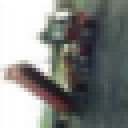

In [38]:
i=10002
random_test_example_X = convert(Array{Float64},X[:, :, :, i])
random_test_example_Y = Y[:, i]
showImage(random_test_example_X)

In [39]:
random_test_example_X_4d = reshape(random_test_example_X, 32, 32, 3, 1)
test_CNN(random_test_example_X_4d, random_test_example_Y)

1.0

So far so good!

## Test on shifted input

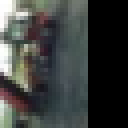

In [40]:
shifted_random_test_example_X = shiftToLeft(random_test_example_X, 10)
showImage(shifted_random_test_example_X)

In [41]:
shifted_random_test_example_X_4d = convert(Array{Float64,4},reshape(shifted_random_test_example_X, 32, 32, 3, 1));
test_CNN(shifted_random_test_example_X_4d, random_test_example_Y)

0.0

So the shifting threw the classifier off!

## Test on rotated input

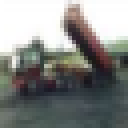

In [42]:
rotated_random_test_example_X = rotate_right(random_test_example_X);
showImage(rotated_random_test_example_X)

In [43]:
rotated_random_test_example_X_4d = convert(Array{Float64,4},reshape(rotated_random_test_example_X, 32, 32, 3, 1));
accuracy(rotated_random_test_example_X_4d, random_test_example_Y)

0.0

In [44]:
w1 = params(m)[1];

In [45]:
function my_init(k1,k2,ch1,ch2)
    Tracker.data(w1)
end

my_init (generic function with 1 method)

In [46]:
m_final = Chain(
    Conv((2,2), 3=>16, relu, init= my_init),
    x -> maxpool(x, (2,2))
)

Chain(Conv((2, 2), 3=>16, NNlib.relu), getfield(Main, Symbol("##15#16"))())

In [47]:
function displayChannels(output_conv)
    imgChannels=[]
    for j=1:size(output_conv, 3)
        ch = output_conv[:, :, j];
        imgrgb = convert(Array{ColorTypes.Gray,2}, Tracker.data(ch))
        push!(imgChannels,imgrgb)
    end
    [imgChannels...]
end

displayChannels (generic function with 1 method)

,,,,,,,,,,,,,,,

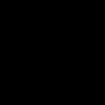
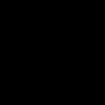
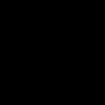
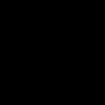
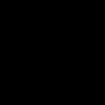
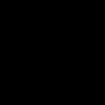
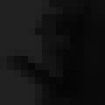
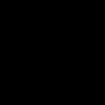
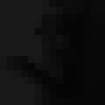
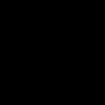
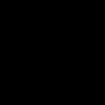
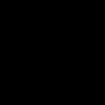
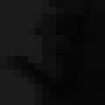
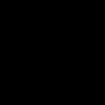
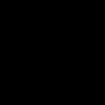
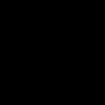

In [48]:
output_conv = m_final(random_test_example_X_4d);
displayChannels(output_conv)

,,,,,,,,,,,,,,,

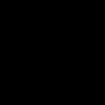
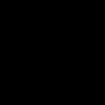
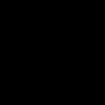
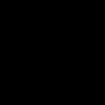
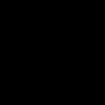
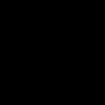
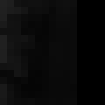
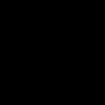
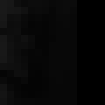
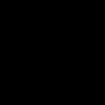
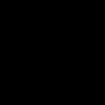
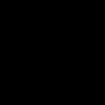
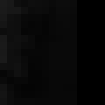
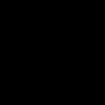
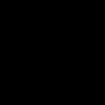
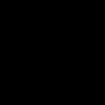

In [49]:
output_conv = m_final(shifted_random_test_example_X_4d);
displayChannels(output_conv)

,,,,,,,,,,,,,,,

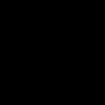
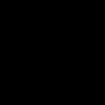
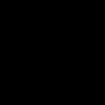
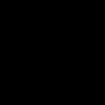
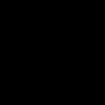
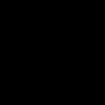
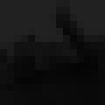
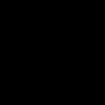
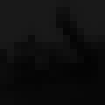
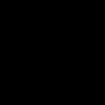
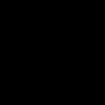
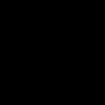
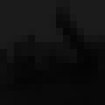
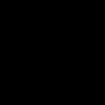
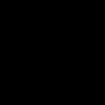
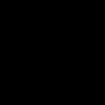

In [50]:
output_conv = m_final(rotated_random_test_example_X_4d);
displayChannels(output_conv)

# NN

In [ ]:
nn_train_x = MLDatasets.CIFAR10.convert2features(X) ./ 255
m_nn = Chain(
    Dense(3072, 2000),
    Dense(2000, 500, relu),
    Dense(500, 10),
    softmax
)

loss_nn(x, y) = crossentropy(m_nn(x), y)

accuracy_nn(x, y) = mean(onecold(m_nn(x)) .== onecold(y))

dataset_nn = repeated((nn_train_x, Y), 100)
evalcb = () -> @show(accuracy_nn(nn_train_x, Y))
opt_nn = ADAM(params(m_nn))

Flux.train!(loss_nn, dataset_nn, opt_nn, cb = throttle(evalcb, 10))

accuracy_nn(nn_train_x, Y) = 0.3333333333333333
accuracy_nn(nn_train_x, Y) = 0.3333333333333333
accuracy_nn(nn_train_x, Y) = 0.3333333333333333
accuracy_nn(nn_train_x, Y) = 0.48793333333333333
accuracy_nn(nn_train_x, Y) = 0.4526
accuracy_nn(nn_train_x, Y) = 0.4388666666666667
accuracy_nn(nn_train_x, Y) = 0.5072666666666666
accuracy_nn(nn_train_x, Y) = 0.5530666666666667
accuracy_nn(nn_train_x, Y) = 0.588
accuracy_nn(nn_train_x, Y) = 0.5983333333333334
accuracy_nn(nn_train_x, Y) = 0.589
accuracy_nn(nn_train_x, Y) = 0.5876


In [ ]:
imgrgb = float2RGB(random_test_example_X)

In [ ]:
accuracy_nn(MLDatasets.CIFAR10.convert2features(random_test_example_X)./255, random_test_example_Y)

In [ ]:
accuracy_nn(MLDatasets.CIFAR10.convert2features(shifted_random_test_example_X_4d)./255, random_test_example_Y)

In [ ]:
accuracy_nn(MLDatasets.CIFAR10.convert2features(rotated_random_test_example_X_4d)./255, random_test_example_Y)